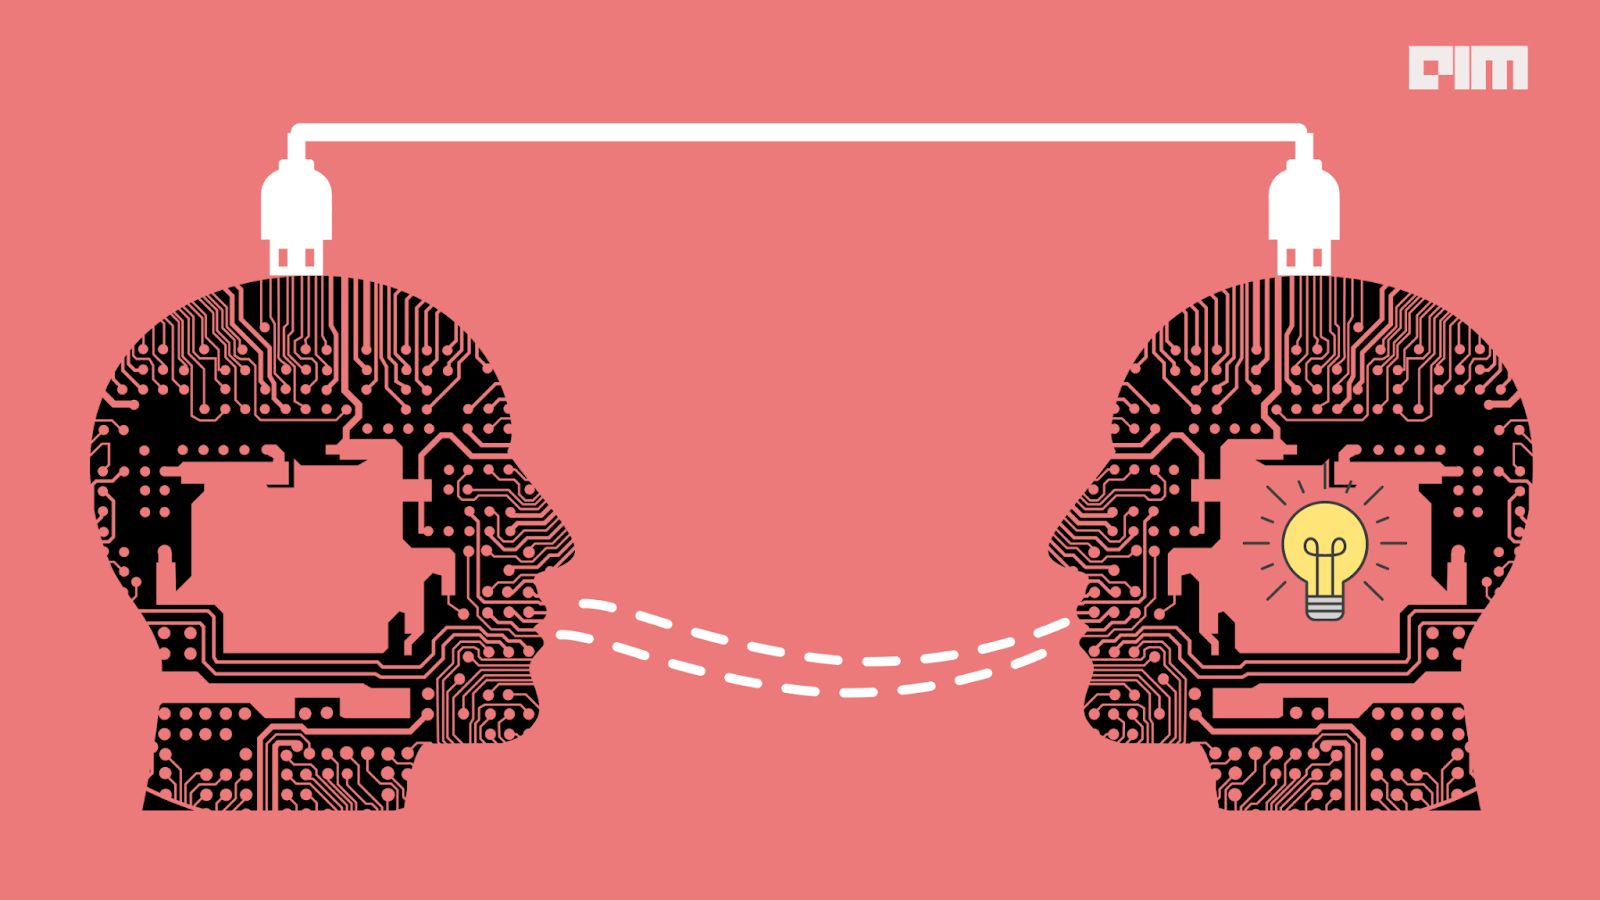

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
import cv2
import zipfile
from skimage import io
import random
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers, layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import *
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, RobustScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam, Adagrad, Adamax, Nadam, SGD, RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import warnings
warnings.filterwarnings('ignore')

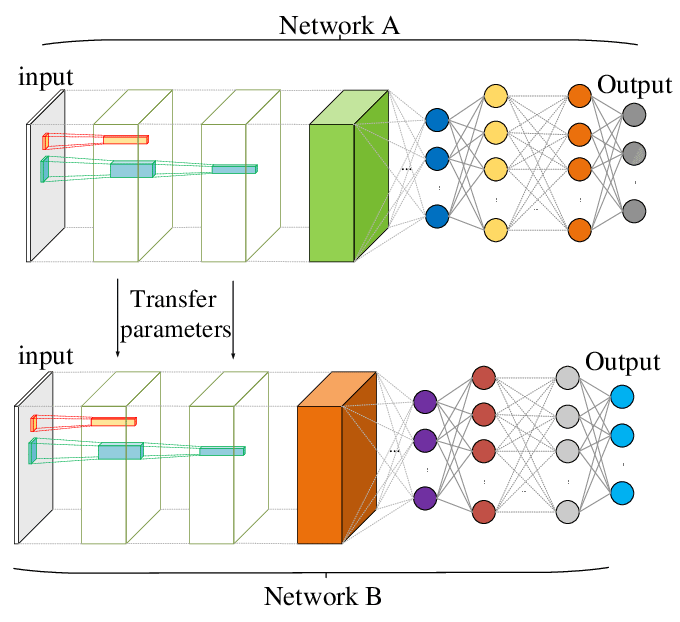

## Some functions before training

In [3]:
''' This function is to prepare data for classification tasks in machine learning,
ensuring that the inputs and outputs are in the proper format to train them effectively.'''
def preprocess_data1(x, y):
  x_data = preprocess_input(x)
  num_of_class = len(set(y))
  y_data = to_categorical(y, num_classes=num_of_class)
  return x_data, y_data

In [4]:
'''Visualizing the training process of a ResNet50 model by plotting the training and validation accuracy,
as well as the training and validation loss over epochs. '''
def show_details(history, model, batch_size, epochs):
  model_name = model,
  f = plt.figure(figsize = (30,4))
  st = f.suptitle(model, fontsize = "x-large")
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(accuracy))
  plt.subplot(1,2,1)

  plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()


  plt.subplot (1,2,2)
  plt.plot(epochs, loss, 'ro', label = 'Training loss')
  plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
##importing dataset
train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/traffic-signs-data (2)/train.p')
valid = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/traffic-signs-data (2)/valid.p')

In [7]:
##checking for keys
print('keys: ', train.keys(), valid.keys())

keys:  dict_keys(['coords', 'labels', 'features', 'sizes']) dict_keys(['coords', 'labels', 'features', 'sizes'])


In [8]:
##splitting data into labels and features
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']

In [9]:
##checking shapes
x_train.shape, x_valid.shape, y_valid.shape, y_train.shape,

((34799, 32, 32, 3), (4410, 32, 32, 3), (4410,), (34799,))

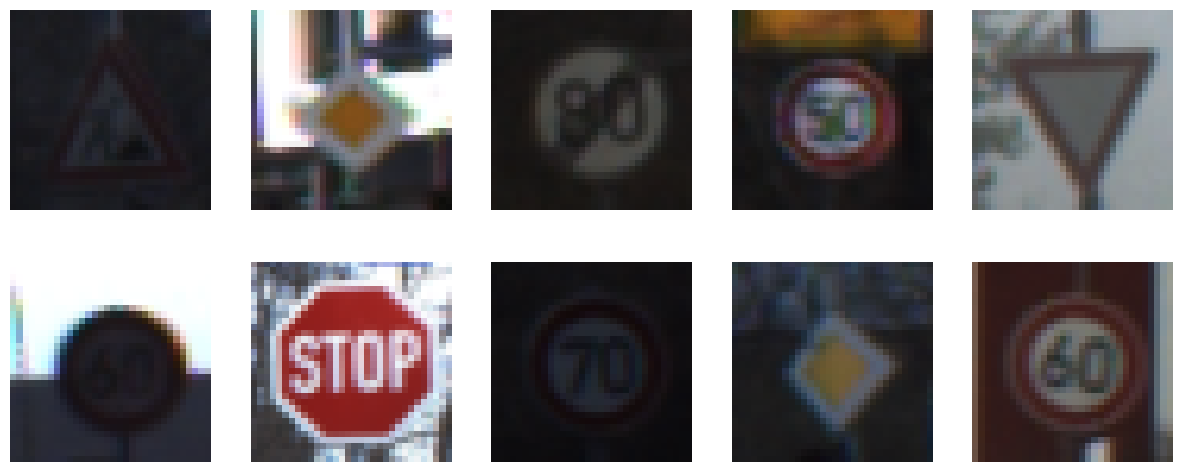

In [10]:
 # Shuffling the indices of x_train so that it would show random images
indices = np.arange(len(x_train))
np.random.shuffle(indices)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    # Selecting the shuffled indexes and displaying the corresponding image
    ax.imshow(x_train[indices[999 + i]])
    ax.axis('off')
plt.show()

## Preprocessing

In [11]:
x_train, y_train = preprocess_data1(x_train, y_train)
x_valid, y_valid = preprocess_data1(x_valid, y_valid)

## Creating an instance of ResNet50 model

In [12]:
model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [13]:
## Summary of the model
print(model_resnet.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [14]:
for layer in model_resnet.layers:
  layer.trainable = False ##freezing the weights of the pre-trained model and preventing any further updates to them.

In [15]:
## calculating the number of unique classes in y_train
num_of_class = len(set(tuple(x) for x in y_train))

In [16]:
'''This code defines model for image classification using Keras. It leverages a pre-trained
ResNet50 model for feature extraction and adds additional custom layers for
classification tailored to a specific number of classes'''
img_size = (224, 224)

model = Sequential()
model.add(Lambda(lambda image: tf.image.resize(image, img_size)))
model.add(model_resnet)

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_class, activation = 'softmax'))

In [17]:
##  This code configures the model to train by optimizing the categorical_crossentropy loss function using the RMSprop optimizer
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [18]:
## Train ResNet50 model using Keras, with the addition of a callback for early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

hist = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 10, batch_size = 100, callbacks=[early_stopping])

Epoch 1/10
348/348 [==============================] - 135s 350ms/step - loss: 2.9271 - accuracy: 0.4063 - val_loss: 1.2507 - val_accuracy: 0.6066
Epoch 2/10
348/348 [==============================] - 122s 351ms/step - loss: 1.0460 - accuracy: 0.6838 - val_loss: 0.8625 - val_accuracy: 0.7408
Epoch 3/10
348/348 [==============================] - 122s 351ms/step - loss: 0.7559 - accuracy: 0.7719 - val_loss: 0.6304 - val_accuracy: 0.8002
Epoch 4/10
348/348 [==============================] - 122s 351ms/step - loss: 0.6016 - accuracy: 0.8205 - val_loss: 0.6924 - val_accuracy: 0.8209
Epoch 5/10
348/348 [==============================] - 122s 352ms/step - loss: 0.5033 - accuracy: 0.8502 - val_loss: 0.5982 - val_accuracy: 0.8433
Epoch 6/10
348/348 [==============================] - 122s 351ms/step - loss: 0.4574 - accuracy: 0.8653 - val_loss: 0.6506 - val_accuracy: 0.8431
Epoch 7/10
348/348 [==============================] - 114s 328ms/step - loss: 0.4122 - accuracy: 0.8792 - val_loss: 0.6462 -

In [19]:
# Save the model to a file
model.save('my_model.h5')

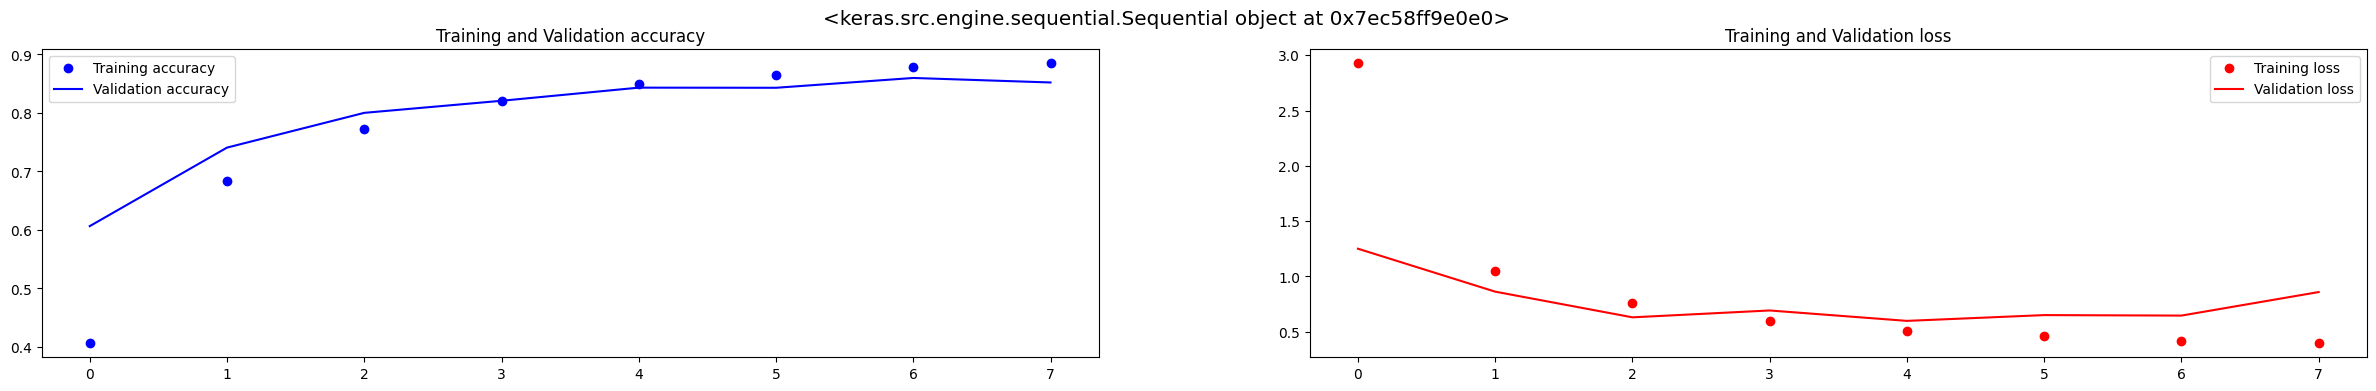

In [20]:
## visually presenting the training history of a model
show_details(hist, model, batch_size = 64, epochs = 8)